In [1]:
%cd ../


/home/hoanghu/projects/Food-Waste-Optimization


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [19]:
path_fact = "experiments_hoangle/processed/fact.xlsx"

fact = pd.read_excel(path_fact, index_col=None)

# 4. Find correlations

## 4.1. Correlations between `num_customers` and `foodwaste`

In [18]:
cols_val = ['num_customer_in', 'amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *cols_val]

df_cus_waste = fact[cols]
df_cus_waste = df_cus_waste[~df_cus_waste.isna().any(axis=1)].sort_values('date')

df_cus_waste.head()

,date,restaurant,num_customer_in,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
1098,2024-03-15,Exactum,26.0,8.60,2.08,5.13,0.0
1099,2024-03-18,Exactum,33.0,3.40,0.86,10.60,0.0
1100,2024-03-19,Exactum,234.0,3.76,1.10,5.40,0.0
1101,2024-03-20,Exactum,372.0,6.89,1.56,9.75,0.0
1102,2024-03-21,Exactum,262.0,3.17,1.67,7.89,0.0


In [19]:
correlations = []
for restaurant in df_cus_waste['restaurant'].unique():
    df_cus_waste_restaurant = df_cus_waste[df_cus_waste['restaurant'] == restaurant]

    corr = df_cus_waste_restaurant[cols_val].corr().iloc[0]
    corr['restaurant'] = restaurant

    correlations.append(corr)

In [20]:
cols = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']

df_corr = pd.DataFrame(correlations).melt(id_vars='restaurant', value_vars=cols, value_name='pearson', var_name='waste_type')

df_corr.head()

,restaurant,waste_type,pearson
0,Exactum,amnt_waste_customer,0.038297
1,Chemicum,amnt_waste_customer,-0.619415
2,Exactum,amnt_waste_coffee,0.161498
3,Chemicum,amnt_waste_coffee,-0.479019
4,Exactum,amnt_waste_kitchen,-0.150543


Text(0.5, 1.0, 'Overall')

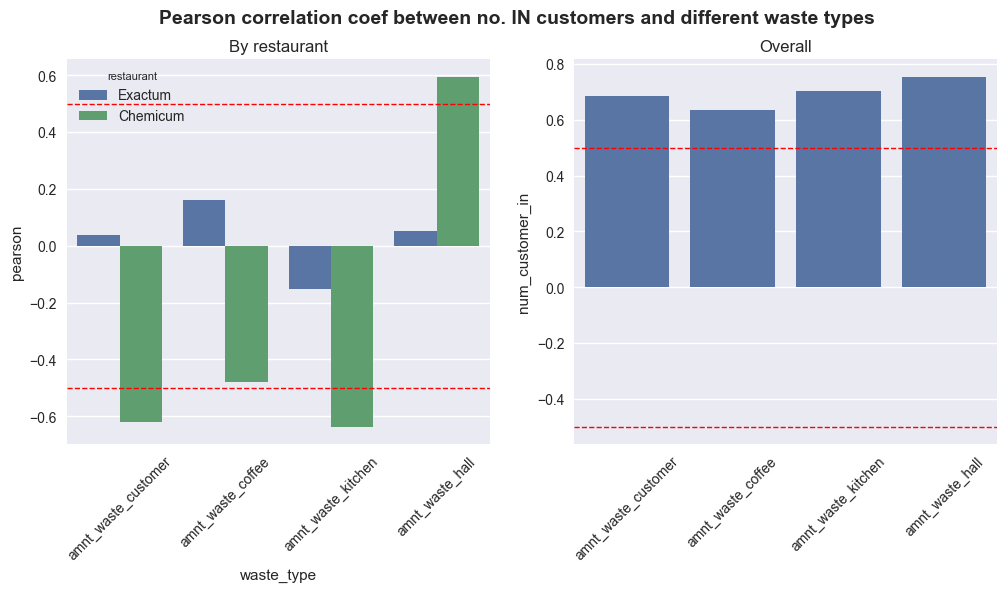

In [21]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pearson correlation coef between no. IN customers and different waste types", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1, 2, 1)
sns.barplot(data=df_corr, x='waste_type', y='pearson', hue='restaurant', ax=ax)
ax.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=1)
ax.axhline(y = -0.5, color = 'r', linestyle = '--', linewidth=1)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("By restaurant")



ax = fig.add_subplot(1, 2, 2)
df_corr_overall = df_cus_waste.sort_values('date')[cols_val].corr().iloc[0][cols]
sns.barplot(data=df_corr_overall, ax=ax)
ax.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=1)
ax.axhline(y = -0.5, color = 'r', linestyle = '--', linewidth=1)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Overall")



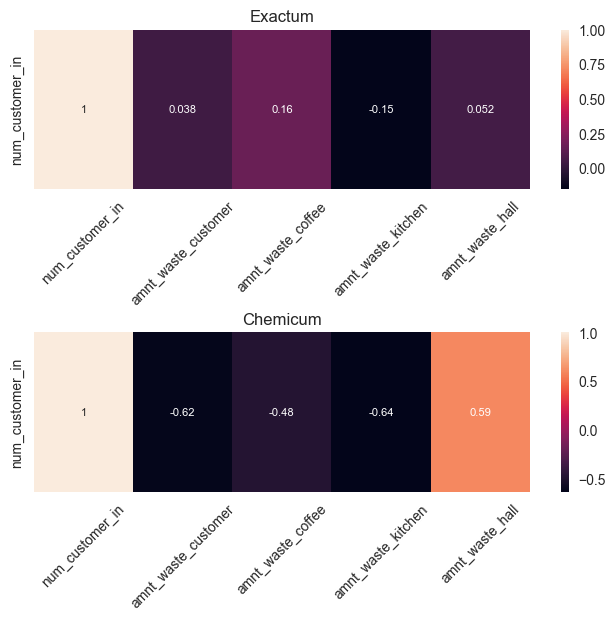

In [22]:
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.9)

for i, restaurant in enumerate(df_cus_waste['restaurant'].unique()):
    df_restaurant = df_cus_waste[df_cus_waste['restaurant'] == restaurant]
    line = df_restaurant[cols_val].corr().iloc[0]
    
    ax = fig.add_subplot(2, 1, i+1)
    sns.heatmap([line.to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line.index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)

## 4.2. Correlations between `num_rcpts` and `foodwaste`

In [23]:
cols_val = ['num_rcpts', 'amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *cols_val]

df_rcpts_waste = fact[cols]
df_rcpts_waste = df_rcpts_waste[~df_rcpts_waste.isna().any(axis=1)]

df_rcpts_waste.head()

,date,restaurant,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,272.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,327.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,351.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,437.0,10.00,3.3,8.5,0.0
5,2023-01-09,Chemicum,529.0,7.65,2.1,4.9,0.0


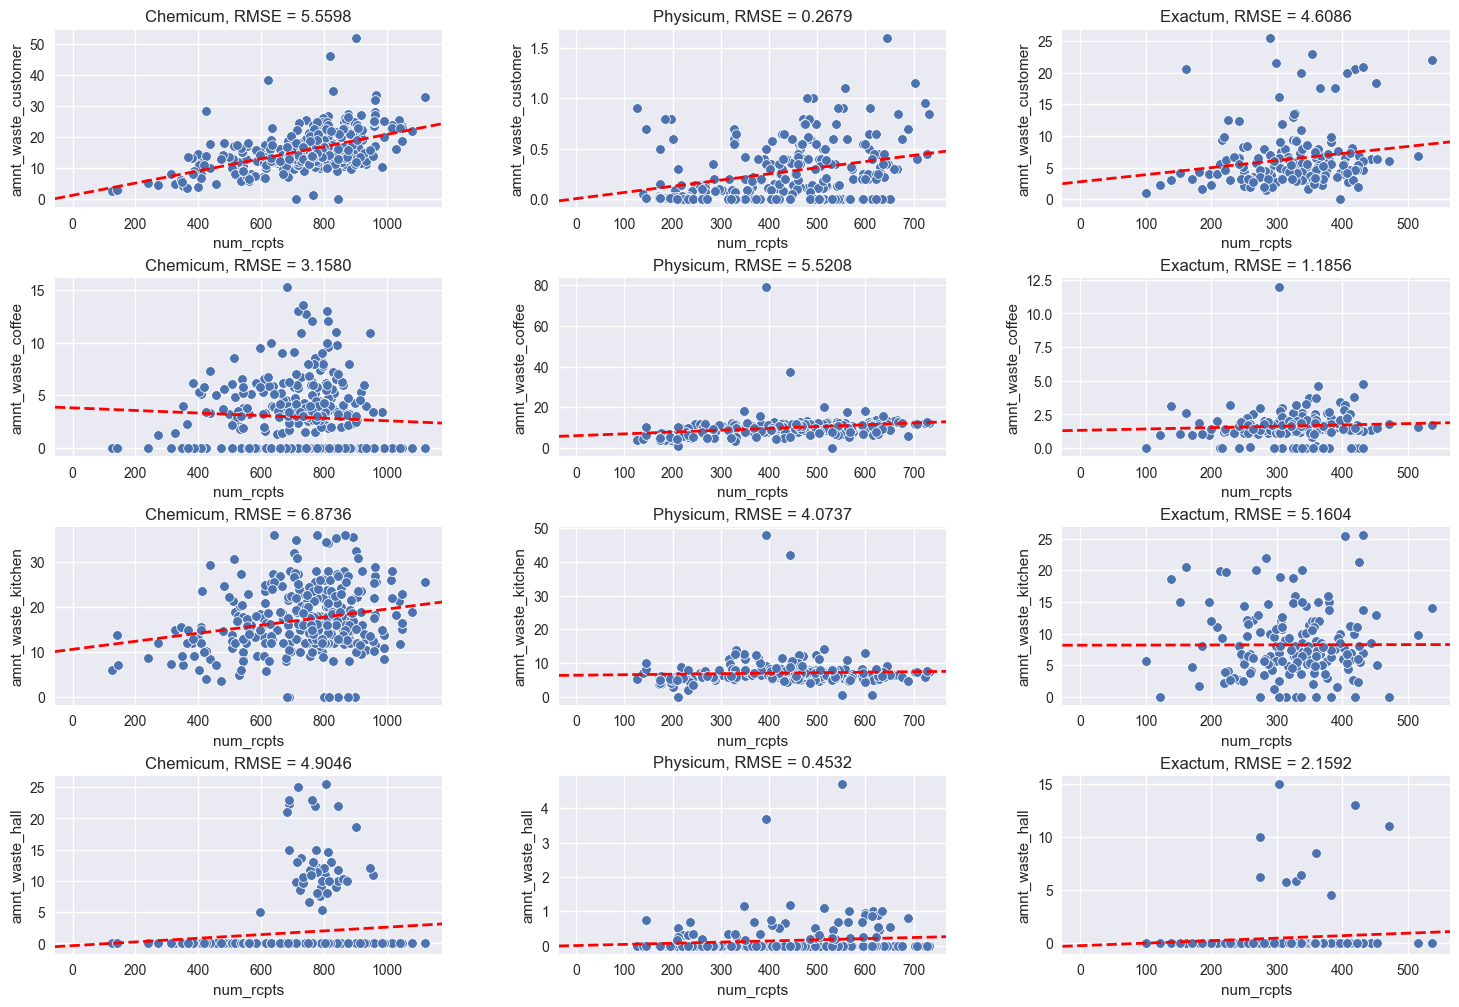

In [24]:
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
i = 1
for waste in waste_types:
    for restaurant in df_rcpts_waste['restaurant'].unique():

        df_restaurant = df_rcpts_waste[df_rcpts_waste['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)

        sns.scatterplot(df_restaurant, x='num_rcpts', y=waste, ax=ax)

        regressor_linear = LinearRegression()

        X = df_restaurant['num_rcpts'].to_numpy().reshape(-1, 1)
        y = df_restaurant[waste].to_numpy().reshape(-1, 1)
        regressor_linear.fit(X, y)

        y_pred = regressor_linear.predict(X)
        rmse_linear = root_mean_squared_error(y, y_pred)

        m, b = regressor_linear.coef_.item(), regressor_linear.intercept_.item()

        ax.axline(xy1=(0, b), slope=m, color='red', linestyle='--', linewidth=2)
        ax.set_title(f"{restaurant}, RMSE = {rmse_linear:.4f}")

        i += 1


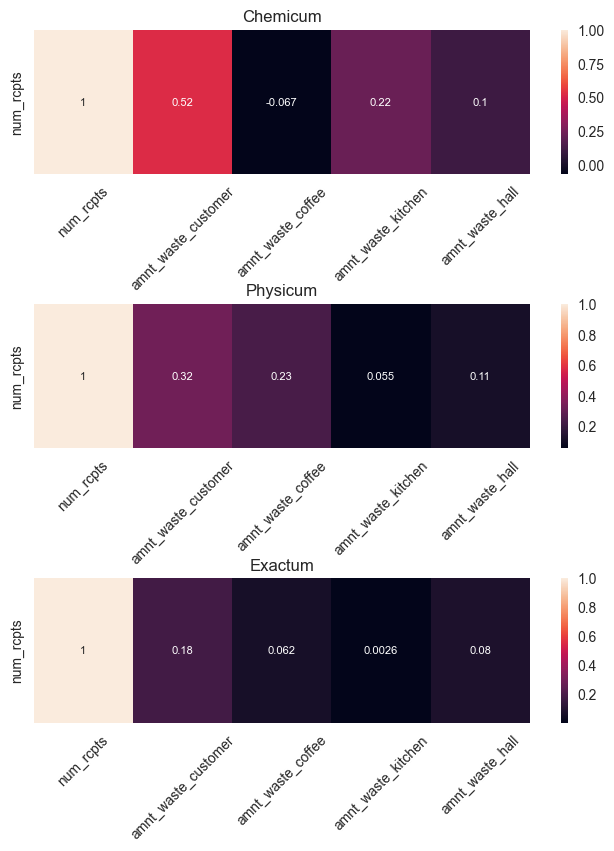

In [27]:
fig = plt.figure(figsize=(8, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.9)

for i, restaurant in enumerate(df_rcpts_waste['restaurant'].unique()):
    df_restaurant = df_rcpts_waste[df_rcpts_waste['restaurant'] == restaurant]
    line = df_restaurant[cols_val].corr().iloc[0]
    
    ax = fig.add_subplot(3, 1, i+1)
    sns.heatmap([line.to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line.index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)

In [28]:
df_rcpts_waste_wkdate = df_rcpts_waste.copy()

# Extract weekday from date
df_rcpts_waste_wkdate['weekdate'] = df_rcpts_waste['date'].dt.weekday

# Groupby weekdate and restaurant
df_rcpts_waste_wkdate = df_rcpts_waste_wkdate\
    .drop(columns='date')\
    .groupby(['weekdate', 'restaurant'])\
    .sum()\
    .reset_index()

# Replace weekdate from numeric to name
weekdate2name = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
}
df_rcpts_waste_wkdate['weekdate'] = df_rcpts_waste_wkdate['weekdate'].replace(weekdate2name)

df_rcpts_waste_wkdate.head()

,weekdate,restaurant,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,Monday,Chemicum,47919.0,945.00,119.40,995.15,104.80
1,Monday,Exactum,12184.0,206.50,56.53,289.88,5.86
2,Monday,Physicum,22606.0,15.68,462.59,339.38,5.99
3,Tuesday,Chemicum,47992.0,993.55,188.20,983.35,111.10
4,Tuesday,Exactum,12171.0,249.70,66.59,302.18,17.54


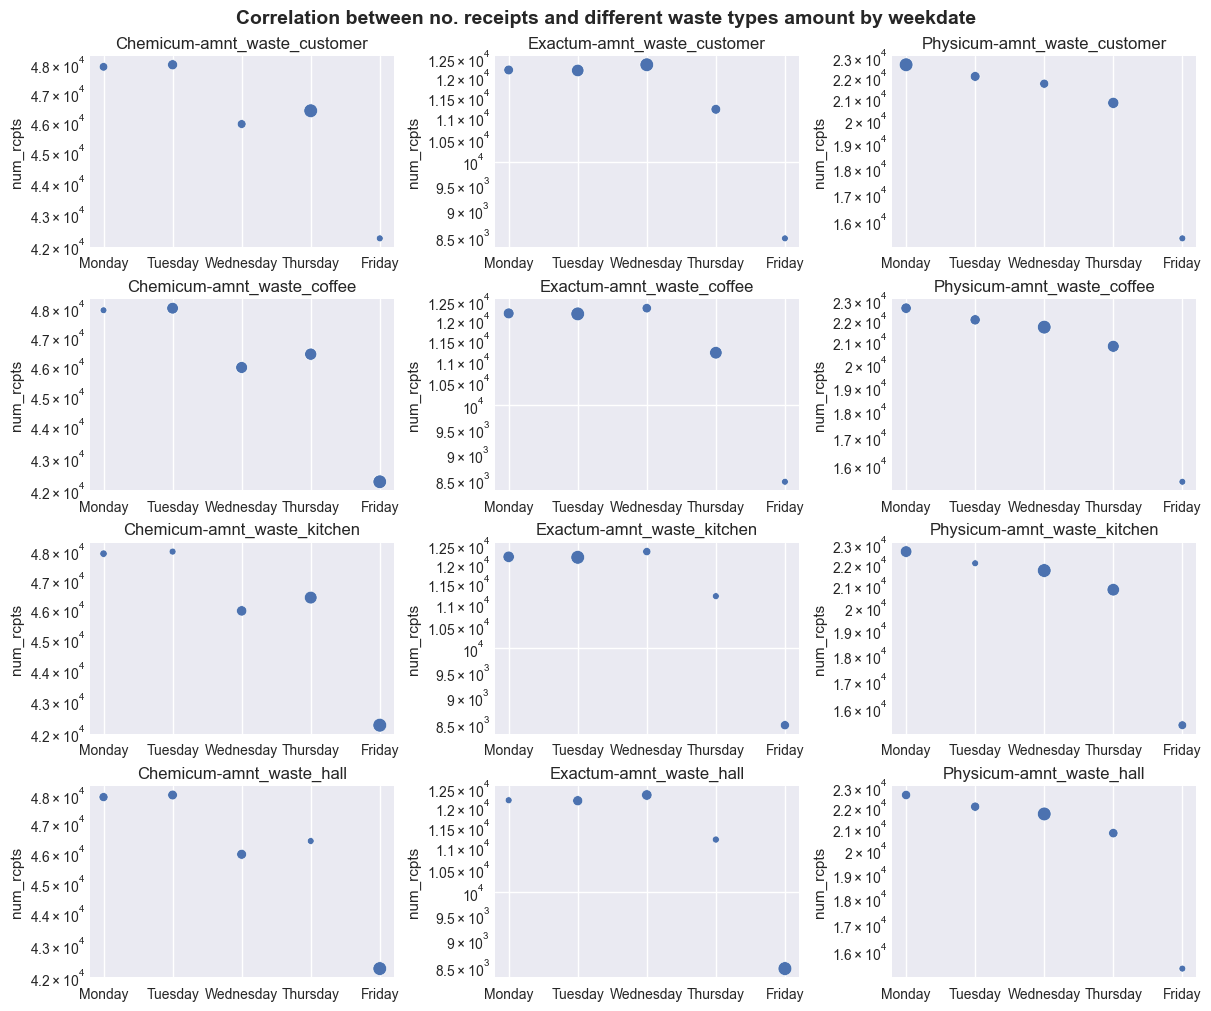

In [29]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

fig.suptitle("Correlation between no. receipts and different waste types amount by weekdate", fontsize=14, fontweight="bold")

i = 1
for waste in waste_types:
    for restaurant in df_rcpts_waste_wkdate['restaurant'].unique():
        df_restaurant = df_rcpts_waste_wkdate[df_rcpts_waste_wkdate['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)
        sns.scatterplot(df_restaurant, x='weekdate', y='num_rcpts', size=waste, ax=ax)
        ax.set_yscale('log')
        ax.set(xlabel=None)
        ax.get_legend().remove()
        ax.set_title(f"{restaurant}-{waste}")

        i += 1
    

## 4.3. Correlations between `meals_sold` and `foodwaste`

In [54]:
meal_types = ['num_fish', 'num_chicken', 'num_vegetarian', 'num_meat', 'num_NotMapped', 'num_vegan']
waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *meal_types, *waste_types]

df_meal_waste = fact[cols].copy()
df_meal_waste = df_meal_waste[~df_meal_waste.isna().any(axis=1)]

df_meal_waste.head()

,date,restaurant,num_fish,num_chicken,num_vegetarian,num_meat,num_NotMapped,num_vegan,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0,10.00,3.3,8.5,0.0
5,2023-01-09,Chemicum,107.0,0.0,0.0,264.0,0.0,207.0,7.65,2.1,4.9,0.0


In [55]:
df_meals_waste_wkdate = df_meal_waste.copy()

# Extract weekday from date
df_meals_waste_wkdate['weekdate'] = df_meals_waste_wkdate['date'].dt.weekday

# Groupby weekdate and restaurant
df_meals_waste_wkdate = df_meals_waste_wkdate\
    .drop(columns='date')\
    .groupby(['weekdate', 'restaurant'])\
    .sum()\
    .reset_index()

# Replace weekdate from numeric to name
weekdate2name = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
}
df_meals_waste_wkdate['weekdate'] = df_meals_waste_wkdate['weekdate'].replace(weekdate2name)

df_meals_waste_wkdate.head()

,weekdate,restaurant,num_fish,num_chicken,num_vegetarian,num_meat,num_NotMapped,num_vegan,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,Monday,Chemicum,9998.0,1477.0,78.0,22556.0,2788.0,16157.0,962.20,122.20,1015.75,120.10
1,Monday,Exactum,6042.0,1255.0,41.0,14307.0,2193.0,10058.0,206.50,56.53,289.88,5.86
2,Monday,Physicum,8786.0,1338.0,67.0,20476.0,2372.0,14323.0,15.68,466.02,347.94,5.99
3,Tuesday,Chemicum,17407.0,2952.0,776.0,3407.0,2933.0,26504.0,1029.85,200.20,1016.55,136.70
4,Tuesday,Exactum,9929.0,1636.0,641.0,1944.0,1770.0,15578.0,249.70,66.59,302.18,17.54


In [56]:
meal_type = "num_vegetarian"

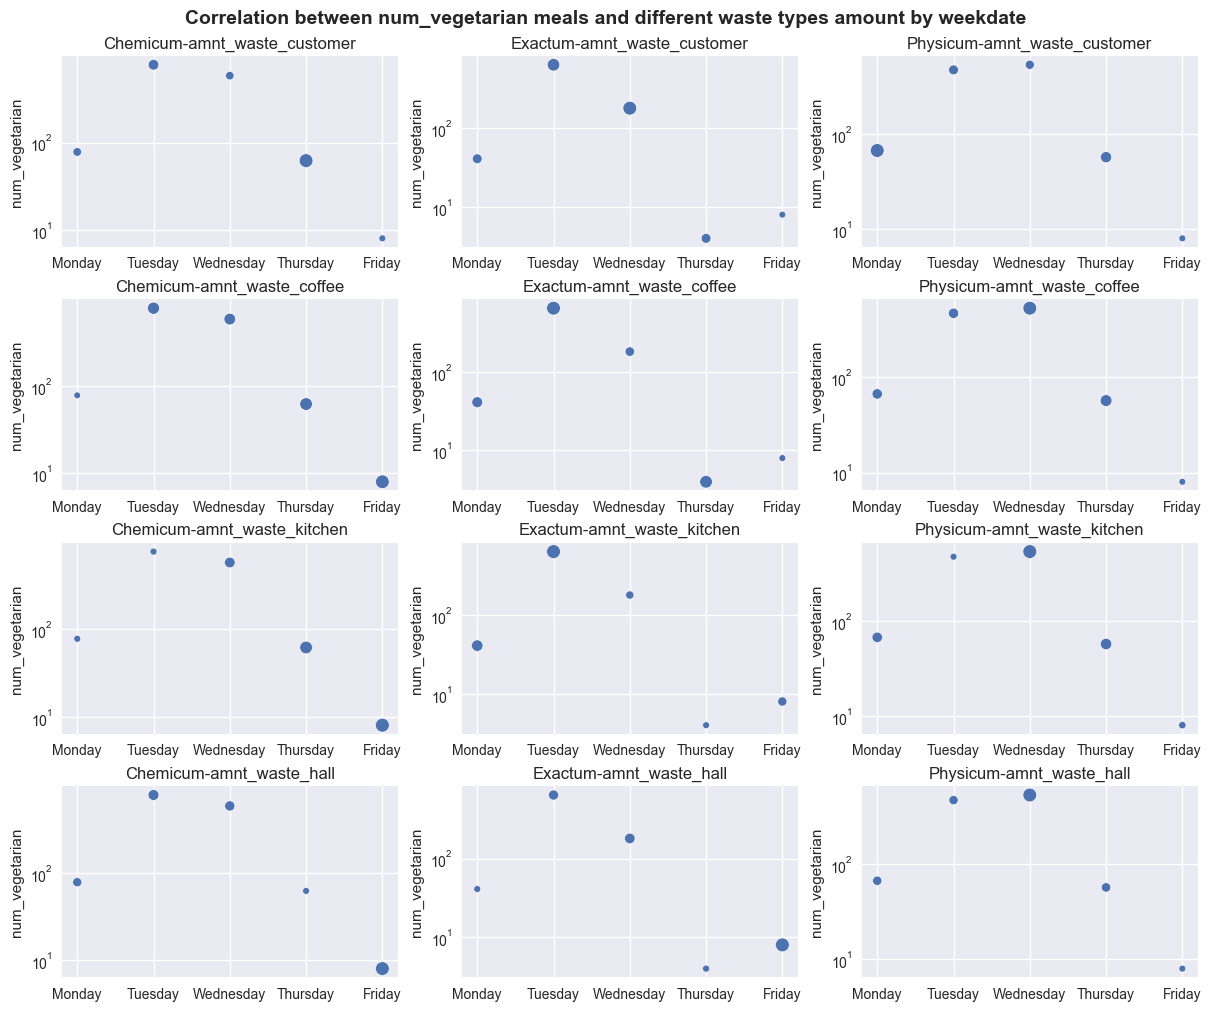

In [57]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

fig.suptitle(f"Correlation between {meal_type} meals and different waste types amount by weekdate", fontsize=14, fontweight="bold")

i = 1
for waste in waste_types:
    for restaurant in df_meals_waste_wkdate['restaurant'].unique():
        df_restaurant = df_meals_waste_wkdate[df_meals_waste_wkdate['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)
        sns.scatterplot(df_restaurant, x='weekdate', y=meal_type, size=waste, ax=ax)
        ax.set_yscale('log')
        ax.set(xlabel=None)
        ax.get_legend().remove()
        ax.set_title(f"{restaurant}-{waste}")

        i += 1

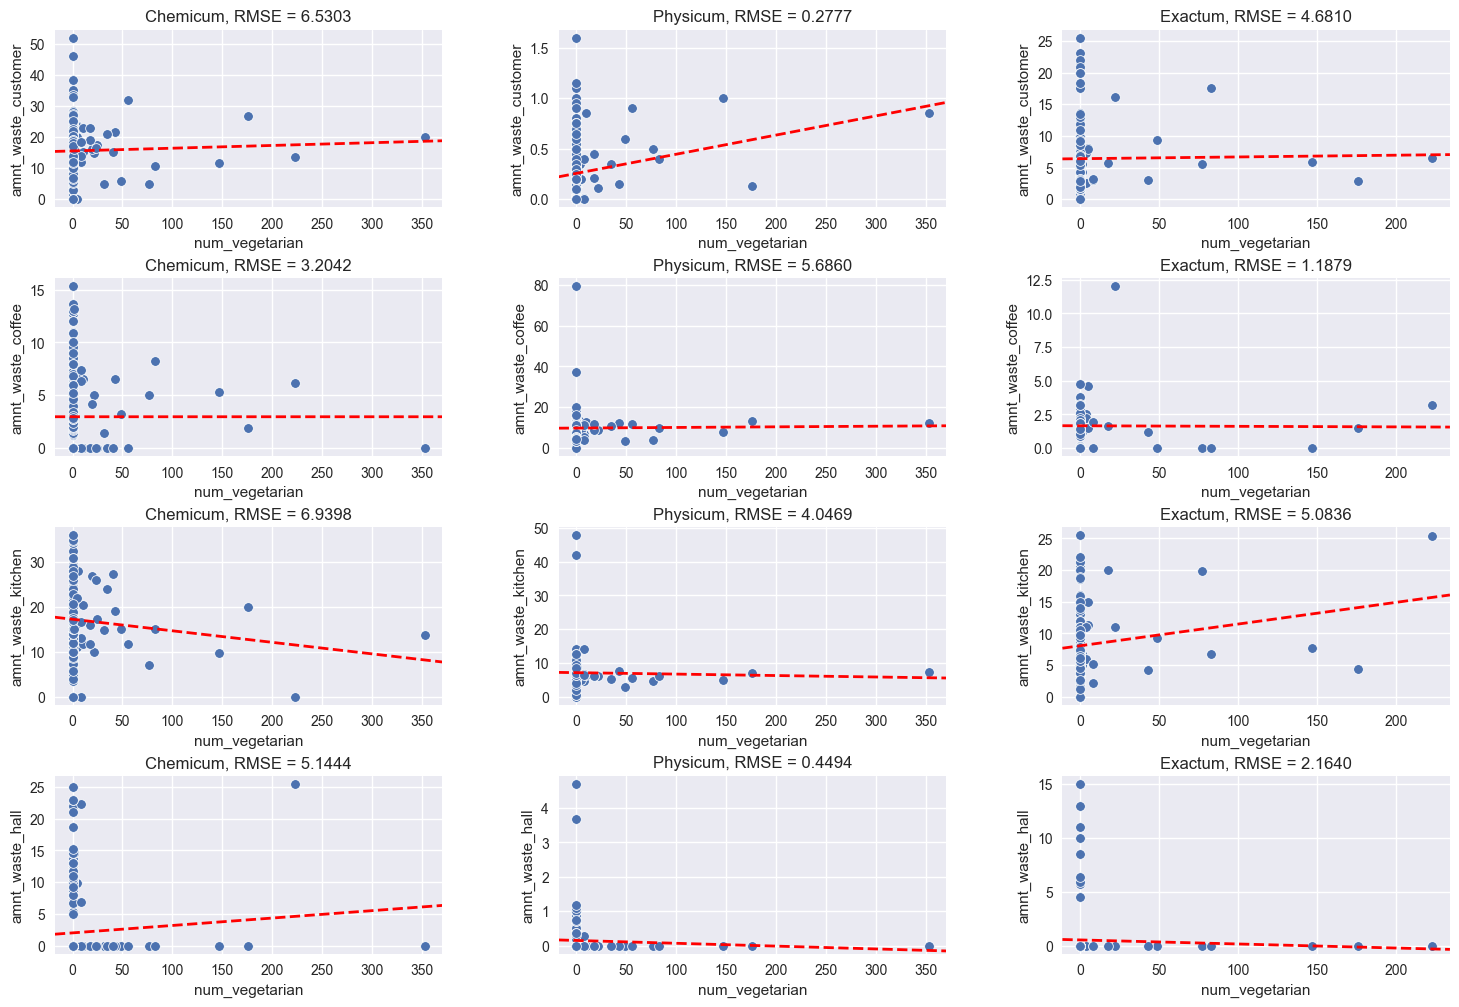

In [58]:
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
i = 1
for waste in waste_types:
    for restaurant in df_meal_waste['restaurant'].unique():

        df_restaurant = df_meal_waste[df_meal_waste['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)

        sns.scatterplot(df_restaurant, x=meal_type, y=waste, ax=ax)

        regressor_linear = LinearRegression()

        X = df_restaurant[meal_type].to_numpy().reshape(-1, 1)
        y = df_restaurant[waste].to_numpy().reshape(-1, 1)
        regressor_linear.fit(X, y)

        y_pred = regressor_linear.predict(X)
        rmse_linear = root_mean_squared_error(y, y_pred)

        m, b = regressor_linear.coef_.item(), regressor_linear.intercept_.item()

        ax.axline(xy1=(0, b), slope=m, color='red', linestyle='--', linewidth=2)
        ax.set_title(f"{restaurant}, RMSE = {rmse_linear:.4f}")

        i += 1


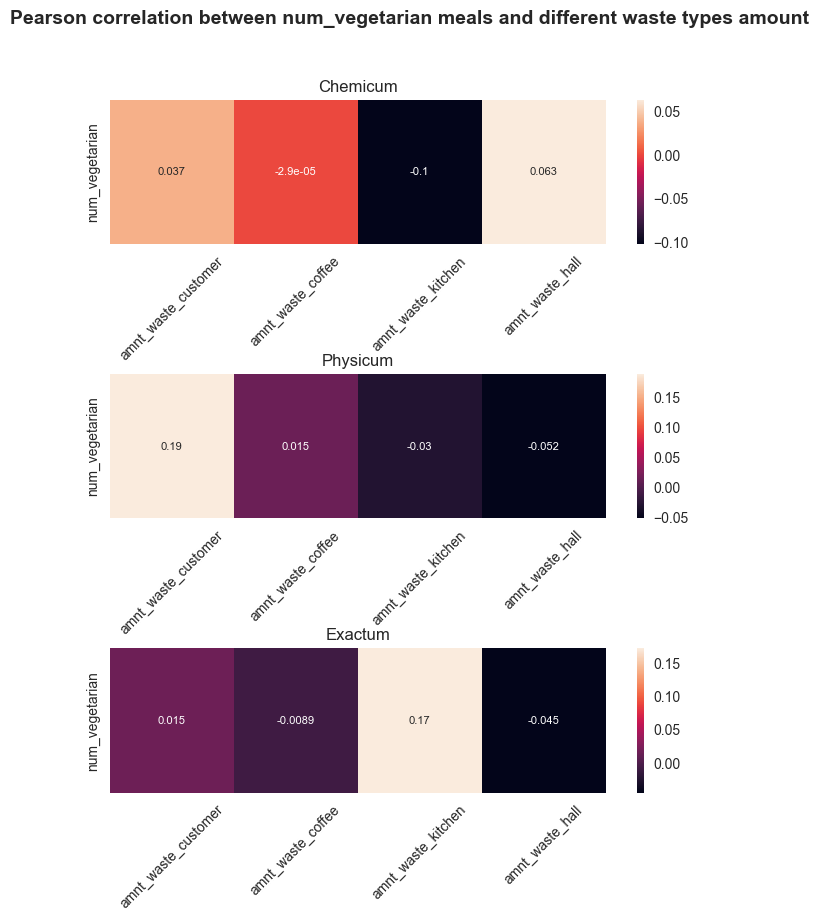

In [59]:
cols = [*meal_types, *waste_types]

fig = plt.figure(figsize=(8, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
fig.suptitle(f"Pearson correlation between {meal_type} meals and different waste types amount", fontsize=14, fontweight="bold")

for i, restaurant in enumerate(df_meal_waste['restaurant'].unique()):
    df_restaurant = df_meal_waste[df_meal_waste['restaurant'] == restaurant]
    line = df_restaurant[cols].corr().loc[meal_type]
    
    ax = fig.add_subplot(3, 1, i+1)
    sns.heatmap([line[waste_types].to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line[waste_types].index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)